In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health/Mental Health Dataset.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC, SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

from category_encoders import LeaveOneOutEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/kaggle/input/mental-health/Mental Health Dataset.csv")
df.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


In [4]:
df.shape


(292364, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Timestamp                292364 non-null  object
 1   Gender                   292364 non-null  object
 2   Country                  292364 non-null  object
 3   Occupation               292364 non-null  object
 4   self_employed            287162 non-null  object
 5   family_history           292364 non-null  object
 6   treatment                292364 non-null  object
 7   Days_Indoors             292364 non-null  object
 8   Growing_Stress           292364 non-null  object
 9   Changes_Habits           292364 non-null  object
 10  Mental_Health_History    292364 non-null  object
 11  Mood_Swings              292364 non-null  object
 12  Coping_Struggles         292364 non-null  object
 13  Work_Interest            292364 non-null  object
 14  Social_Weakness     

In [6]:
df.duplicated().sum()

2313

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.isnull().sum()

Timestamp                     0
Gender                        0
Country                       0
Occupation                    0
self_employed              5193
family_history                0
treatment                     0
Days_Indoors                  0
Growing_Stress                0
Changes_Habits                0
Mental_Health_History         0
Mood_Swings                   0
Coping_Struggles              0
Work_Interest                 0
Social_Weakness               0
mental_health_interview       0
care_options                  0
dtype: int64

In [9]:
df.dropna(inplace=True)

**Use level encoding**

In [10]:
le = LabelEncoder()

df["Gender"] = le.fit_transform(df["Gender"])
df["self_employed"] = le.fit_transform(df["self_employed"])
df["family_history"] = le.fit_transform(df["family_history"])
df["treatment"] = le.fit_transform(df["treatment"])
df["Coping_Struggles"] = le.fit_transform(df["Coping_Struggles"])

In [11]:
data = pd.get_dummies(data=df, columns=["Occupation", "Days_Indoors", "Growing_Stress",
            "Changes_Habits", "Mental_Health_History", "Work_Interest", "Social_Weakness",
            "mental_health_interview", "care_options"])

data = pd.get_dummies(data=data, columns=["Mood_Swings"])

In [12]:
data

,Timestamp,Gender,Country,self_employed,family_history,treatment,Coping_Struggles,Occupation_Business,Occupation_Corporate,Occupation_Housewife,...,Social_Weakness_Yes,mental_health_interview_Maybe,mental_health_interview_No,mental_health_interview_Yes,care_options_No,care_options_Not sure,care_options_Yes,Mood_Swings_High,Mood_Swings_Low,Mood_Swings_Medium
3,8/27/2014 11:37,0,United States,0,1,1,0,False,True,False,...,True,True,False,False,False,False,True,False,False,True
4,8/27/2014 11:43,0,United States,0,1,1,0,False,True,False,...,True,False,True,False,False,False,True,False,False,True
5,8/27/2014 11:49,0,Poland,0,0,1,0,False,True,False,...,True,True,False,False,False,True,False,False,False,True
6,8/27/2014 11:51,0,Australia,0,1,1,0,False,True,False,...,True,False,True,False,False,True,False,False,False,True
7,8/27/2014 11:52,0,United States,0,0,0,0,False,True,False,...,True,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292359,7/27/2015 23:25,1,United States,1,1,1,1,True,False,False,...,False,True,False,False,False,True,False,False,True,False
292360,8/17/2015 9:38,1,South Africa,0,1,1,1,True,False,False,...,False,False,True,False,False,False,True,False,True,False
292361,8/25/2015 19:59,1,United States,0,1,0,1,True,False,False,...,False,False,True,False,True,False,False,False,True,False
292362,9/26/2015 1:07,1,United States,0,1,1,1,True,False,False,...,False,False,True,False,False,False,True,False,True,False


In [13]:
data.drop("Timestamp", axis=1, inplace=True)

In [14]:
leave_encoder = LeaveOneOutEncoder()
data["Country"] = leave_encoder.fit_transform(data["Country"], data.iloc[:, -3])

In [15]:
data

,Gender,Country,self_employed,family_history,treatment,Coping_Struggles,Occupation_Business,Occupation_Corporate,Occupation_Housewife,Occupation_Others,...,Social_Weakness_Yes,mental_health_interview_Maybe,mental_health_interview_No,mental_health_interview_Yes,care_options_No,care_options_Not sure,care_options_Yes,Mood_Swings_High,Mood_Swings_Low,Mood_Swings_Medium
3,0,0.312640,0,1,1,0,False,True,False,False,...,True,True,False,False,False,False,True,False,False,True
4,0,0.312640,0,1,1,0,False,True,False,False,...,True,False,True,False,False,False,True,False,False,True
5,0,0.320732,0,0,1,0,False,True,False,False,...,True,True,False,False,False,True,False,False,False,True
6,0,0.314652,0,1,1,0,False,True,False,False,...,True,False,True,False,False,True,False,False,False,True
7,0,0.312640,0,0,0,0,False,True,False,False,...,True,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292359,1,0.312640,1,1,1,1,True,False,False,False,...,False,True,False,False,False,True,False,False,True,False
292360,1,0.313065,0,1,1,1,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False
292361,1,0.312640,0,1,0,1,True,False,False,False,...,False,False,True,False,True,False,False,False,True,False
292362,1,0.312640,0,1,1,1,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False


In [16]:
df

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
3,8/27/2014 11:37,0,United States,Corporate,0,1,1,1-14 days,Yes,No,Yes,Medium,0,No,Yes,Maybe,Yes
4,8/27/2014 11:43,0,United States,Corporate,0,1,1,1-14 days,Yes,No,Yes,Medium,0,No,Yes,No,Yes
5,8/27/2014 11:49,0,Poland,Corporate,0,0,1,1-14 days,Yes,No,Yes,Medium,0,No,Yes,Maybe,Not sure
6,8/27/2014 11:51,0,Australia,Corporate,0,1,1,1-14 days,Yes,No,Yes,Medium,0,No,Yes,No,Not sure
7,8/27/2014 11:52,0,United States,Corporate,0,0,0,1-14 days,Yes,No,Yes,Medium,0,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292359,7/27/2015 23:25,1,United States,Business,1,1,1,15-30 days,No,Maybe,No,Low,1,No,Maybe,Maybe,Not sure
292360,8/17/2015 9:38,1,South Africa,Business,0,1,1,15-30 days,No,Maybe,No,Low,1,No,Maybe,No,Yes
292361,8/25/2015 19:59,1,United States,Business,0,1,0,15-30 days,No,Maybe,No,Low,1,No,Maybe,No,No
292362,9/26/2015 1:07,1,United States,Business,0,1,1,15-30 days,No,Maybe,No,Low,1,No,Maybe,No,Yes


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 284858 entries, 3 to 292363
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Gender                           284858 non-null  int64  
 1   Country                          284858 non-null  float64
 2   self_employed                    284858 non-null  int64  
 3   family_history                   284858 non-null  int64  
 4   treatment                        284858 non-null  int64  
 5   Coping_Struggles                 284858 non-null  int64  
 6   Occupation_Business              284858 non-null  bool   
 7   Occupation_Corporate             284858 non-null  bool   
 8   Occupation_Housewife             284858 non-null  bool   
 9   Occupation_Others                284858 non-null  bool   
 10  Occupation_Student               284858 non-null  bool   
 11  Days_Indoors_1-14 days           284858 non-null  bool   
 12  Days_In

# Visualization

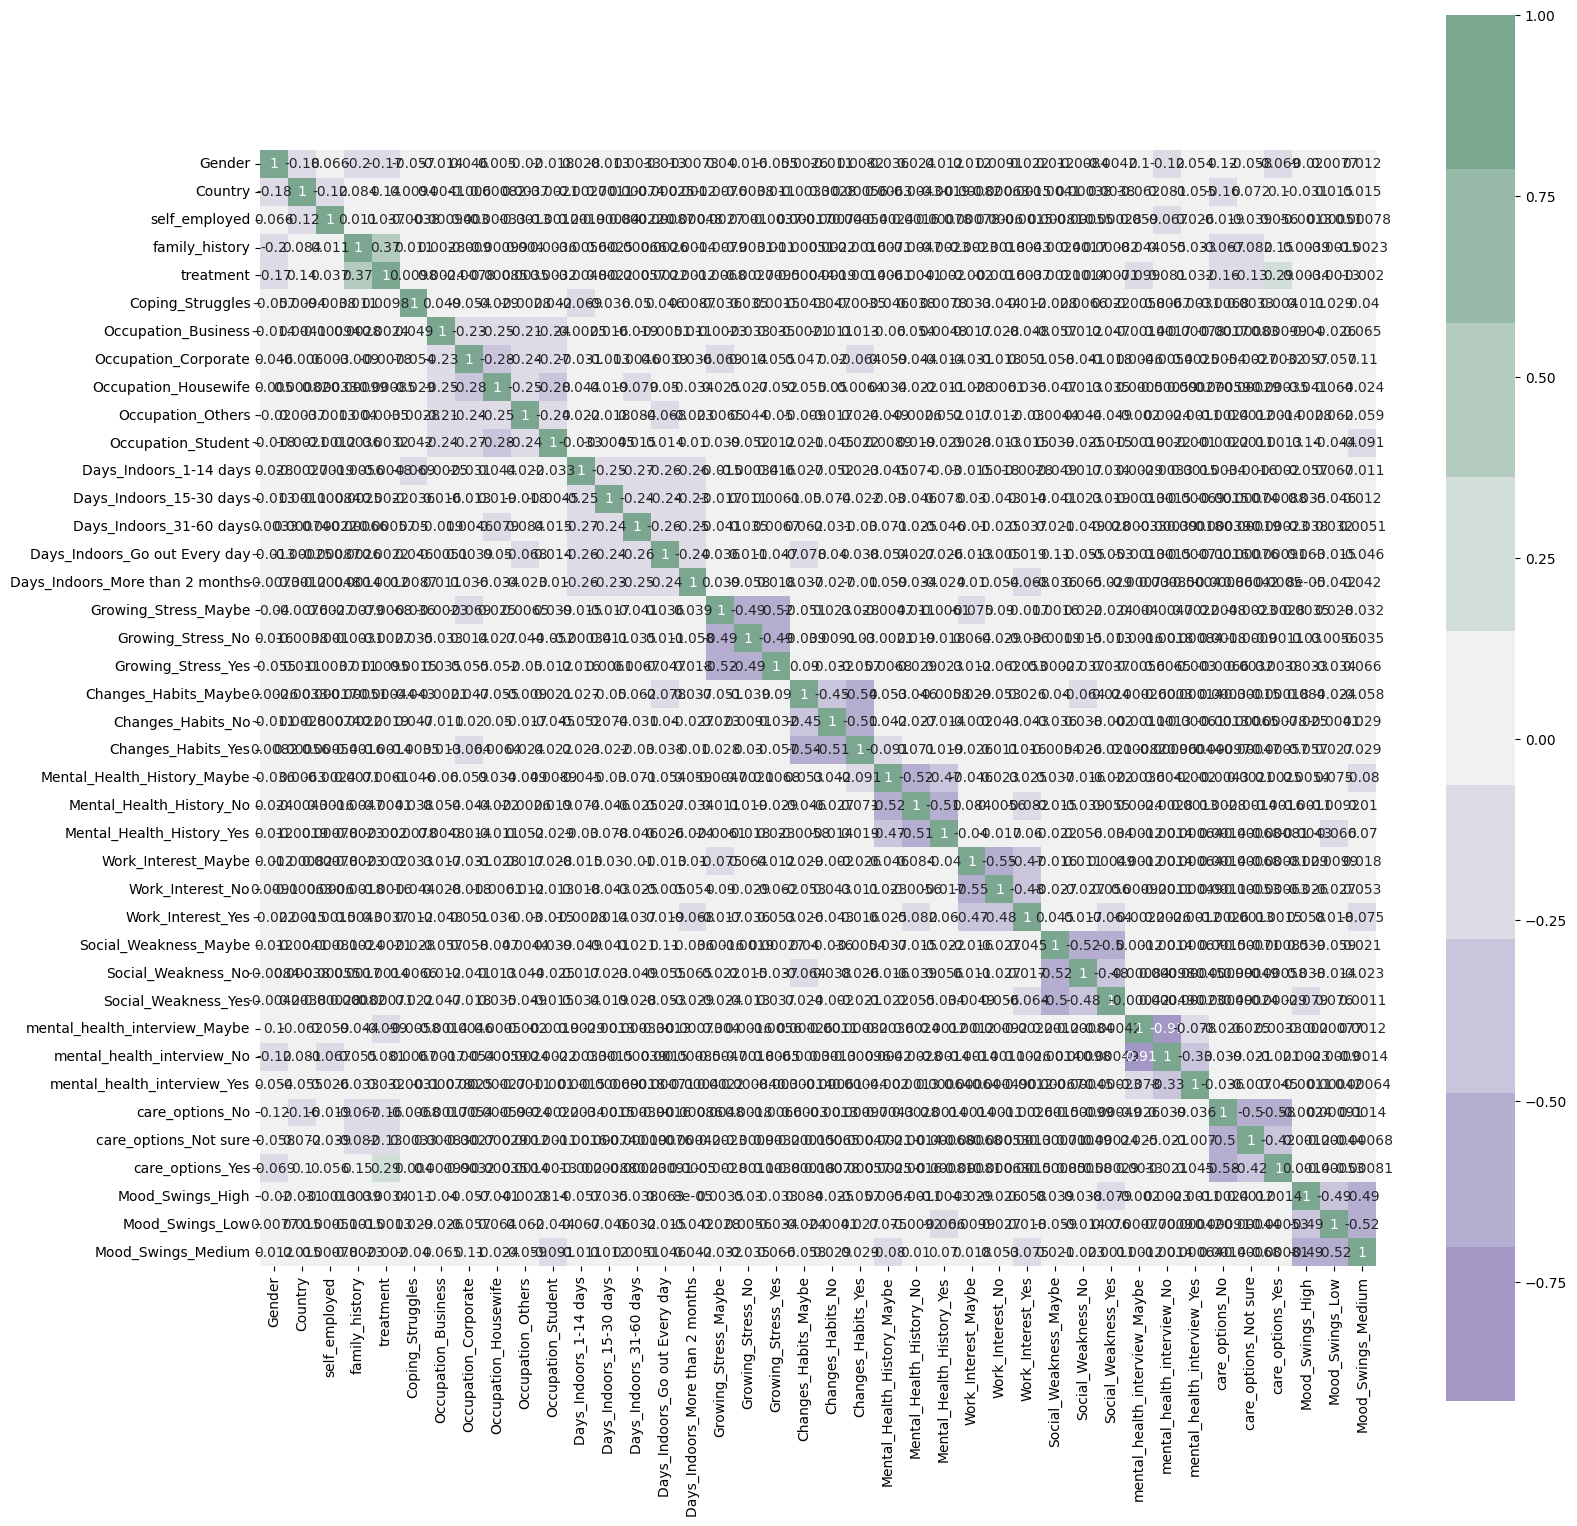

In [18]:
cmap = sns.diverging_palette(275,150,  s=40, l=65, n=9)
corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True);

In [20]:
# Days_of_week=sns.countplot(x=df['age'],data=df, hue ="DEATH_EVENT",palette = cols)
# Days_of_week.set_title("Distribution Of Age", color="#774571")

# Prediction

In [28]:
y = data.iloc[:, -3:]
X = data.drop(data.iloc[:, -3:], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [29]:
X.shape

(284858, 37)

In [30]:
y.shape

(284858, 3)

In [31]:

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [32]:
model_list = [LinearSVC(), LogisticRegression(), GradientBoostingClassifier(),
              AdaBoostClassifier(), HistGradientBoostingClassifier()]

roc_auc_list = []
accuracy_list = []

for model in model_list: 
    multi_class = MultiOutputClassifier(model, n_jobs=-1)
    for i in data.iloc[:, -3:]:
        multi_class.fit(X_train, y_train[[i]])
        y_pred = multi_class.predict(X_test)
        roc_auc = roc_auc_score(y_test[i], y_pred)
        accuracy = accuracy_score(y_test[[i]], y_pred)
        
        roc_auc_list.append(roc_auc)
        accuracy_list.append(accuracy)

In [33]:
accuracy_df = pd.DataFrame(accuracy_list, columns=["value"])
roc_auc_df = pd.DataFrame(roc_auc_list, columns=["value"])

In [34]:
list_models = ["LinearSVC", "LogisticRegression", "GradientBoostingClassifier",
               "AdaBoostClassifier", "HistGradientBoostingClassifier"]

In [35]:
accuracy_averages = [accuracy_df.value[:3].mean(), accuracy_df.value[3:6].mean(), accuracy_df.value[6:9].mean(),
                    accuracy_df.value[9:12].mean(), accuracy_df.value[12:15].mean()]

roc_auc_averages = [roc_auc_df.value[:3].mean(), roc_auc_df.value[3:6].mean(), roc_auc_df.value[6:9].mean(),
                    roc_auc_df.value[9:12].mean(), roc_auc_df.value[12:15].mean()]

avarage_df = pd.DataFrame(accuracy_averages, columns=["accuracy_mean"], index=list_models)
avarage_df["roc_auc_mean"] = roc_auc_averages

In [36]:
avarage_df.head()

,accuracy_mean,roc_auc_mean
LinearSVC,0.677639,0.533617
LogisticRegression,0.678376,0.538641
GradientBoostingClassifier,0.887641,0.866949
AdaBoostClassifier,0.805639,0.762074
HistGradientBoostingClassifier,0.992417,0.991666


In [37]:
roc_auc_list = []
accuracy_list = []

hist_class = MultiOutputClassifier(HistGradientBoostingClassifier(), n_jobs=-1)
print("HistGradientBoostingClassifier SELECTED MODEL\n")

for i in data.iloc[:,-3:].columns:
    hist_class.fit(X_train, y_train[[i]])
    y_pred = hist_class.predict(X_test)
    roc_auc = roc_auc_score(y_test[[i]], y_pred)
    accuracy = accuracy_score(y_test[[i]], y_pred)
    
    roc_auc_list.append(roc_auc)
    accuracy_list.append(accuracy)
            
    print(f'Category name: {i}')
    print(f'{i} AUC ROC score is: {roc_auc:.3f}')
    print(f"accuracy score is: {accuracy:.3f}")
    print("\n", "-" * 50)

HistGradientBoostingClassifier SELECTED MODEL

Category name: Mood_Swings_High
Mood_Swings_High AUC ROC score is: 1.000
accuracy score is: 1.000

 --------------------------------------------------
Category name: Mood_Swings_Low
Mood_Swings_Low AUC ROC score is: 0.987
accuracy score is: 0.986

 --------------------------------------------------
Category name: Mood_Swings_Medium
Mood_Swings_Medium AUC ROC score is: 0.983
accuracy score is: 0.986

 --------------------------------------------------


In [38]:
k = 1
l = 2
i = 0
j = 3
for model_name in list_models:
    
    print(f"Accuracy scores of categories with {model_name}: {accuracy_df.value[i:j].mean()}")
    
    print(f"Roc_auc_scores of categories with {model_name}: {roc_auc_df.value[i:j].mean()}")
    
    plt.tight_layout()

Accuracy scores of categories with LinearSVC: 0.6776389181430255
Roc_auc_scores of categories with LinearSVC: 0.5336168830855835
Accuracy scores of categories with LogisticRegression: 0.6776389181430255
Roc_auc_scores of categories with LogisticRegression: 0.5336168830855835
Accuracy scores of categories with GradientBoostingClassifier: 0.6776389181430255
Roc_auc_scores of categories with GradientBoostingClassifier: 0.5336168830855835
Accuracy scores of categories with AdaBoostClassifier: 0.6776389181430255
Roc_auc_scores of categories with AdaBoostClassifier: 0.5336168830855835
Accuracy scores of categories with HistGradientBoostingClassifier: 0.6776389181430255
Roc_auc_scores of categories with HistGradientBoostingClassifier: 0.5336168830855835


<Figure size 640x480 with 0 Axes>

In [39]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

model_list = [LinearSVC(), LogisticRegression(), GradientBoostingClassifier(),
              AdaBoostClassifier(), HistGradientBoostingClassifier()]

roc_auc_list = []
accuracy_list = []

for model in model_list: 
    multi_class = MultiOutputClassifier(model, n_jobs=-1)
    for i in data.iloc[:, -3:]:
        multi_class.fit(X_train, y_train[[i]])
        y_pred = multi_class.predict(X_test)
        roc_auc = roc_auc_score(y_test[i], y_pred)
        accuracy = accuracy_score(y_test[[i]], y_pred)
        
        roc_auc_list.append(roc_auc)
        accuracy_list.append(accuracy)

In [40]:
accuracy_df = pd.DataFrame(accuracy_list, columns=["value"])
roc_auc_df = pd.DataFrame(roc_auc_list, columns=["value"])
list_models = ["LinearSVC", "LogisticRegression", "GradientBoostingClassifier",
               "AdaBoostClassifier", "HistGradientBoostingClassifier"]

In [41]:
accuracy_averages = [accuracy_df.value[:3].mean(), accuracy_df.value[3:6].mean(), accuracy_df.value[6:9].mean(),
                    accuracy_df.value[9:12].mean(), accuracy_df.value[12:15].mean()]

roc_auc_averages = [roc_auc_df.value[:3].mean(), roc_auc_df.value[3:6].mean(), roc_auc_df.value[6:9].mean(),
                    roc_auc_df.value[9:12].mean(), roc_auc_df.value[12:15].mean()]

avarage_df = pd.DataFrame(accuracy_averages, columns=["accuracy_mean"], index=list_models)
avarage_df["roc_auc_mean"] = roc_auc_averages

In [42]:
avarage_df.head()

,accuracy_mean,roc_auc_mean
LinearSVC,0.677639,0.533617
LogisticRegression,0.678376,0.538641
GradientBoostingClassifier,0.887641,0.866949
AdaBoostClassifier,0.805639,0.762074
HistGradientBoostingClassifier,0.990728,0.989737


In [43]:
df

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
3,8/27/2014 11:37,0,United States,Corporate,0,1,1,1-14 days,Yes,No,Yes,Medium,0,No,Yes,Maybe,Yes
4,8/27/2014 11:43,0,United States,Corporate,0,1,1,1-14 days,Yes,No,Yes,Medium,0,No,Yes,No,Yes
5,8/27/2014 11:49,0,Poland,Corporate,0,0,1,1-14 days,Yes,No,Yes,Medium,0,No,Yes,Maybe,Not sure
6,8/27/2014 11:51,0,Australia,Corporate,0,1,1,1-14 days,Yes,No,Yes,Medium,0,No,Yes,No,Not sure
7,8/27/2014 11:52,0,United States,Corporate,0,0,0,1-14 days,Yes,No,Yes,Medium,0,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292359,7/27/2015 23:25,1,United States,Business,1,1,1,15-30 days,No,Maybe,No,Low,1,No,Maybe,Maybe,Not sure
292360,8/17/2015 9:38,1,South Africa,Business,0,1,1,15-30 days,No,Maybe,No,Low,1,No,Maybe,No,Yes
292361,8/25/2015 19:59,1,United States,Business,0,1,0,15-30 days,No,Maybe,No,Low,1,No,Maybe,No,No
292362,9/26/2015 1:07,1,United States,Business,0,1,1,15-30 days,No,Maybe,No,Low,1,No,Maybe,No,Yes


In [44]:
hist_high = MultiOutputClassifier(HistGradientBoostingClassifier(), n_jobs=-1).fit(X_train, y_train[["Mood_Swings_High"]])
hist_low = MultiOutputClassifier(HistGradientBoostingClassifier(), n_jobs=-1).fit(X_train, y_train[["Mood_Swings_Low"]])
hist_medium = MultiOutputClassifier(HistGradientBoostingClassifier(), n_jobs=-1).fit(X_train, y_train[["Mood_Swings_Medium"]])

pred_high = hist_high.predict(X_test)
pred_low = hist_low.predict(X_test)
pred_medium = hist_medium.predict(X_test)

In [45]:
# Mood Swings (High)
print(classification_report(y_test["Mood_Swings_High"], pred_high))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     58948
        True       1.00      1.00      1.00     26510

    accuracy                           1.00     85458
   macro avg       1.00      1.00      1.00     85458
weighted avg       1.00      1.00      1.00     85458



In [46]:
cm_high = confusion_matrix(y_test["Mood_Swings_High"], pred_high)
cm_low = confusion_matrix(y_test["Mood_Swings_Low"], pred_low)
cm_medium = confusion_matrix(y_test["Mood_Swings_Medium"], pred_medium)

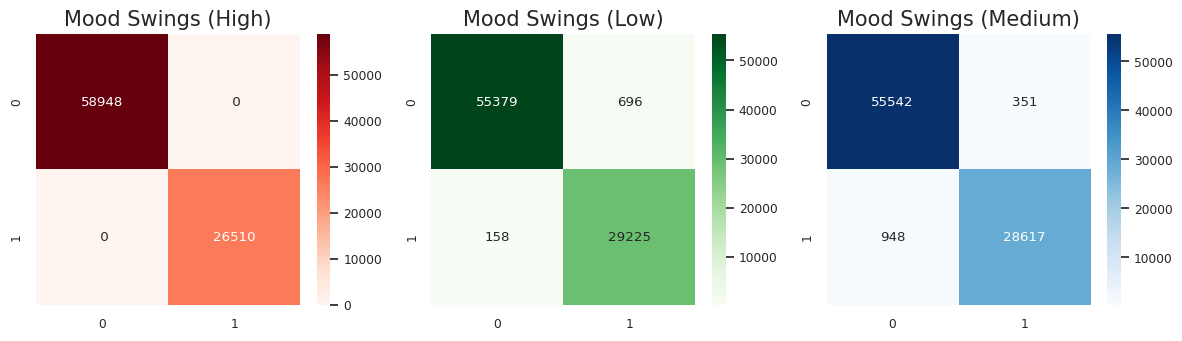

In [47]:
plt.figure(figsize=(12,3.5))
sns.set(font_scale=0.8)
plt.subplot(1,3,1)
sns.heatmap(cm_high, annot=True, fmt='2g', cmap="Reds")
plt.title("Mood Swings (High)", fontsize=15)
plt.subplot(1,3,2)
sns.heatmap(cm_low, annot=True, fmt='2g', cmap="Greens")
plt.title("Mood Swings (Low)", fontsize=15)
plt.subplot(1,3,3)
sns.heatmap(cm_medium, annot=True, fmt='2g', cmap="Blues")
plt.title("Mood Swings (Medium)", fontsize=15)
plt.tight_layout()
plt.show()

In [48]:
y_prob_high = hist_high.predict_proba(X_test)[0][:, 1]
y_prob_low = hist_low.predict_proba(X_test)[0][:, 1]
y_prob_medium = hist_medium.predict_proba(X_test)[0][:, 1]

fpr_h, tpr_h, thresholds_h = roc_curve(y_test["Mood_Swings_High"], y_prob_high)
fpr_l, tpr_l, thresholds_l = roc_curve(y_test["Mood_Swings_Low"], y_prob_low)
fpr_m, tpr_m, thresholds_m = roc_curve(y_test["Mood_Swings_Medium"], y_prob_medium)

roc_auc_h = auc(fpr_h, tpr_h)
roc_auc_l = auc(fpr_l, tpr_l)
roc_auc_m = auc(fpr_m, tpr_m)

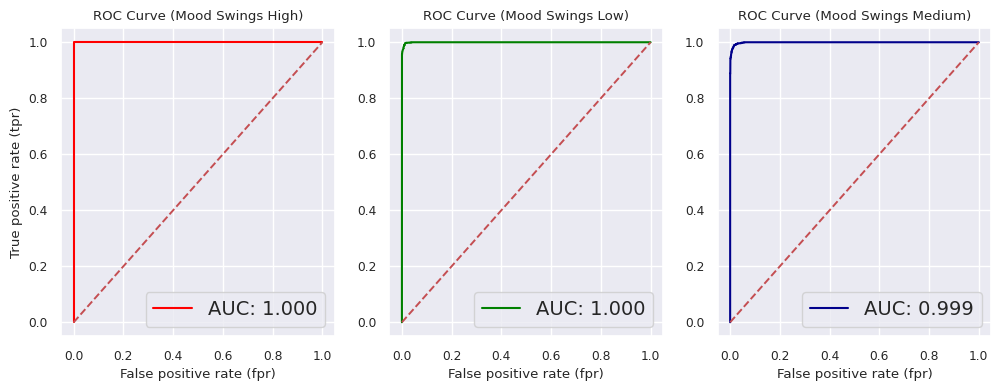

In [49]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(fpr_h, tpr_h, color="red", label= f"AUC: {roc_auc_h:.3f}")
plt.plot([0, 1], [0, 1], color="r", linestyle="--", linewidth=1.4)
plt.legend(fontsize=14)
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.title("ROC Curve (Mood Swings High)")
plt.subplot(1,3,2)
plt.plot(fpr_l, tpr_l, color="Green", label= f"AUC: {roc_auc_l:.3f}")
plt.plot([0, 1], [0, 1], color="r", linestyle="--", linewidth=1.4)
plt.legend(fontsize=14)
plt.xlabel("False positive rate (fpr)")
plt.title("ROC Curve (Mood Swings Low)")
plt.subplot(1,3,3)
plt.plot(fpr_m, tpr_m, color="darkblue", label= f"AUC: {roc_auc_m:.3f}")
plt.plot([0, 1], [0, 1], color="r", linestyle="--", linewidth=1.4)
plt.legend(fontsize=14)
plt.xlabel("False positive rate (fpr)")
plt.title("ROC Curve (Mood Swings Medium)")
plt.show()

In [50]:
data.sample(3)

,Gender,Country,self_employed,family_history,treatment,Coping_Struggles,Occupation_Business,Occupation_Corporate,Occupation_Housewife,Occupation_Others,...,Social_Weakness_Yes,mental_health_interview_Maybe,mental_health_interview_No,mental_health_interview_Yes,care_options_No,care_options_Not sure,care_options_Yes,Mood_Swings_High,Mood_Swings_Low,Mood_Swings_Medium
255820,1,0.312640,0,0,0,1,True,False,False,False,...,False,False,True,False,False,True,False,False,False,True
176040,1,0.312563,0,1,1,1,False,False,True,False,...,False,False,True,False,True,False,False,True,False,False
16365,0,0.312640,0,1,1,1,False,False,True,False,...,False,False,True,False,False,False,True,False,False,True


In [51]:
data.shape

(284858, 40)

In [52]:
X_train.shape

(199400, 37)

# ANN

In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [54]:


# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Early Stopping
early_stopping = EarlyStopping(
    min_delta=0.001,  
    patience=20,  
    restore_best_weights=True
)

# Model Architecture
model = Sequential()
model.add(Dense(37, activation='relu', input_dim=X_train.shape[1]))  # Increase neurons
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))

# Output Layer
model.add(Dense(3, activation='sigmoid'))  # Use 'softmax' if labels are exclusive

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),  
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for exclusive labels
              metrics=['accuracy'])



In [55]:

# Train Model
history = model.fit(
    X_train_scaled, y_train,  
    batch_size=64, epochs=100,  
    callbacks=[early_stopping],  
    validation_split=0.2,
    class_weight={0: 1, 1: 2, 2: 2}  # Adjust if labels are imbalanced
)

Epoch 1/100
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.4167 - loss: 1.0103 - val_accuracy: 0.7432 - val_loss: 0.3925
Epoch 2/100
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6676 - loss: 0.6681 - val_accuracy: 0.8233 - val_loss: 0.2835
Epoch 3/100
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7247 - loss: 0.5660 - val_accuracy: 0.8566 - val_loss: 0.2355
Epoch 4/100
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7511 - loss: 0.5119 - val_accuracy: 0.8581 - val_loss: 0.2156
Epoch 5/100
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7660 - loss: 0.4798 - val_accuracy: 0.8653 - val_loss: 0.2036
Epoch 6/100
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7746 - loss: 0.4549 - val_accuracy: 0.8667 - val_loss: 0.2010
Epoch 7/100
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7832 - loss: 0.4406 - val_accuracy: 0.8699 - val_loss: 0.1885
Epoch 8/100
2493/2493 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7885 - loss: 

In [56]:

# Evaluate Model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9149 - loss: 0.1337
Test Accuracy: 0.9139


# Using gredient decent  ( Backpropagation )

In [57]:
from keras.optimizers import SGD
import tensorflow as tf

# Use SGD with momentum for stable updates
optimizer = SGD(learning_rate=0.01, momentum=0.9)


In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [59]:

# Define the Model
model = Sequential([
    Dense(37, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(3, activation='sigmoid')  # Use 'softmax' if labels are exclusive
])


In [69]:

# Define Loss Function and Optimizer (SGD for manual backpropagation)
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Custom Training Loop
epochs = 20
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).batch(batch_size)

for epoch in range(epochs):
    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0

    for X_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            loss = loss_fn(y_batch, y_pred)  # Compute loss
        
        gradients = tape.gradient(loss, model.trainable_variables)  # Compute gradients
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # Update weights
        
        epoch_loss += loss.numpy()

        # Compute Accuracy (Fix Type Mismatch)
        y_pred_labels = tf.round(y_pred)  # Convert probabilities to 0 or 1
        correct_predictions += tf.reduce_sum(tf.cast(tf.equal(y_pred_labels, tf.cast(y_batch, tf.float32)), tf.float32)).numpy()
        total_samples += tf.size(y_batch).numpy()  # Total number of labels

    epoch_accuracy = correct_predictions / total_samples  # Multi-label accuracy
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")



Epoch 1/1, Loss: 700.5240, Accuracy: 0.8944


**Use Learning Rate Scheduling**

In [74]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.96, staircase=True
)
optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)


In [77]:
# Custom Training Loop
epochs = 10
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).batch(batch_size)

for epoch in range(epochs):
    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0

    for X_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            loss = loss_fn(y_batch, y_pred)  # Compute loss
        
        gradients = tape.gradient(loss, model.trainable_variables)  # Compute gradients
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # Update weights
        
        epoch_loss += loss.numpy()

        # Compute Accuracy (Fix Type Mismatch)
        y_pred_labels = tf.round(y_pred)  # Convert probabilities to 0 or 1
        correct_predictions += tf.reduce_sum(tf.cast(tf.equal(y_pred_labels, tf.cast(y_batch, tf.float32)), tf.float32)).numpy()
        total_samples += tf.size(y_batch).numpy()  # Total number of labels

    epoch_accuracy = correct_predictions / total_samples  # Multi-label accuracy
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")



Epoch 1/10, Loss: 700.3954, Accuracy: 0.8951
Epoch 2/10, Loss: 698.3670, Accuracy: 0.8950
Epoch 3/10, Loss: 692.7062, Accuracy: 0.8959
Epoch 4/10, Loss: 697.7142, Accuracy: 0.8950


KeyboardInterrupt: 

# Deploy the model


In [84]:
import pickle

# Save the model
with open("mental_health_model", "wb") as file:
    pickle.dump(model, file)


In [86]:
with open('mental_health_model','rb') as file: 
    mp = pickle.load(file)